In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

In [3]:
# Définition des noms fichiers, du path principal et de qques variables #

data_path = '/home/monteiro/STAGEIENM3/data_S2M/alp_flat/reanalysis/'
name_file_pro = 'PRO_1958080106_1959080106.nc'
name_file_met = 'FORCING_1958080106_1959080106.nc'

name_file_meteo = 'Rainf_Snowf_1958_2018.nc'
name_file_metadata = 'others_dims_1958_2018.nc'

# Par région #

reg_NW = [1,2,3,4,5]
reg_North = [6,7,8,9,10,11,12]
reg_Central = [13,14]
reg_South = [15,16,17,18,19,20,21]
reg_Far_South = [22,23]
all_reg = [reg_NW,reg_North,reg_Central,reg_South,reg_Far_South]
all_reg_name = ['reg_NW','reg_North','reg_Central','reg_South','reg_Far_South']
range_ZS = np.arange(0,5100,300)

# Type d'altitude #
# Les tranche d'altitudes se font +- 150m

alt_plaine = [0,  300,  600] 
alt_basse = [900, 1200, 1500]
alt_moyenne = [1800, 2100, 2400, 2700]
alt_haute = [ 3000,3300, 3600, 3900, 4200, 4500, 4800]
range_ZS = [alt_plaine,alt_basse,alt_moyenne,alt_haute]
all_ZS = np.arange(0,5100,300)
range_ZS_name = [str(alt_plaine[0])+'-'+str(alt_plaine[-1]+150),str(alt_basse[0]-150)+'-'+str(alt_basse[-1]+150),str(alt_moyenne[0]-150)+'-'+str(alt_moyenne[-1]+150),str(alt_haute[0]-150)+'-'+str(alt_haute[-1])]

year = np.arange(1959,2019,1)

# Climatologie #

yr_11, yr_12 = 1961,1990
yr_21, yr_22 = 1991,2018
yr_1 = [1961,1990]
yr_2 = [1991,2018]

# Chargement des fichiers #

file_extra = xr.open_dataset(data_path+name_file_metadata)
file_extra = file_extra.isel(time=0)
file_meteo = xr.open_dataset(data_path+name_file_meteo)
file_meteo = (file_meteo*3600).resample(time='1D').sum() # Est-ce que je fait vraiment ce traitement ?
PR_tot = (file_meteo.Rainf+file_meteo.Snowf)

In [4]:
###########################
### Fonction Calc_ratio ###
###########################

def calc_ratio(data):
    return (data.Snowf/(data.Rainf+data.Snowf))

In [5]:
##########################################################
# Calcul de la moyenne mensuelle/saisonniere ou annuelle #
##########################################################

# Cut automatically the first and last years as they r incomplete

def calc_mean(data,mean_type, skipna = True):
    
    ds_mean = []
    
    if mean_type == 'month':
        
        num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
        ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

        ds_res = data.resample(time='1MS').sum(skipna = skipna)
        
        for i in range(0,len(num_index)):
            ds_month = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_month = ds_month.groupby('time.year').mean('time',skipna = skipna)
            ds_mean.append(ds_month)
            
        ds_mean = xr.concat(ds_mean,dim='month')
        ds_mean = ds_mean.isel(year=slice(1,-1))
        ds_mean['month'] = ls_name

    if mean_type == 'season':
        
        num_index = [11,2,5,8]
        ls_name = ['SON','DJF','MAM','JJA']

        ds_res = data.resample(time='Q-FEB').sum(skipna = skipna)
        
        for i in range(0,len(num_index)):
            ds_season = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_season = ds_season.groupby('time.year').mean('time',skipna = skipna)
            ds_mean.append(ds_season)
       
        ds_mean = xr.concat(ds_mean,dim='season')
        ds_mean = ds_mean.isel(year=slice(1,-1))
        ds_mean['season'] = ls_name
        
    if mean_type == 'year':

        ds_mean = data.groupby('time.year').sum(skipna = skipna)
        ds_mean = ds_mean.isel(year = slice(1,-1))
    
    return ds_mean

In [6]:
#######################################################################################
### Extrait des subsets de l'espace et fais l'ecart type intra categories du subset ###
#######################################################################################

# Tenter de remplacer Number of points par une dim generique
# Remplacer egalement la fonction calc_ratio par generique

def data_per_x(data,sthg,ls_sthg,ls_sthg_name,data_extra): #STHG = string de la variable, data = wat u want, ls_sthg = valeur intra catégories(liste de listes), ls_sthg_name = Nom des catégorie
    
    data_per_x = []
    std_intra_x = []
    
    for i in range(0,len(ls_sthg)):
        ds_res = data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])).mean(dim='Number_of_points')
        std = (calc_ratio(data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])))).std(dim='Number_of_points')
        data_per_x.append(ds_res)
        std_intra_x.append(std)

    data_per_x = xr.concat(data_per_x,dim = sthg)
    data_per_x[sthg] = ls_sthg_name
    std_intra_x = xr.concat(std_intra_x,dim =sthg)
    std_intra_x[sthg] = ls_sthg_name
    
    return std_intra_x,data_per_x

### Fonction extraction des indices ###

def iextract(data,variable,extract_list): # data = file_extra, variable = 'massif_number' or 'ZS', extract_list = Quelle liste/entier altitude ou de massif
    data = data[variable]
    iextract_list = []
    for i in range(0,len(data)):
        
        if type(extract_list) == int or type(extract_list) == np.int64 :
            if data[i].values == extract_list:
                iextract_list.append(i)
                
        else:
            for j in range(0,len(extract_list)):
                if data[i].values == extract_list[j]:
                    iextract_list.append(i)
    return iextract_list

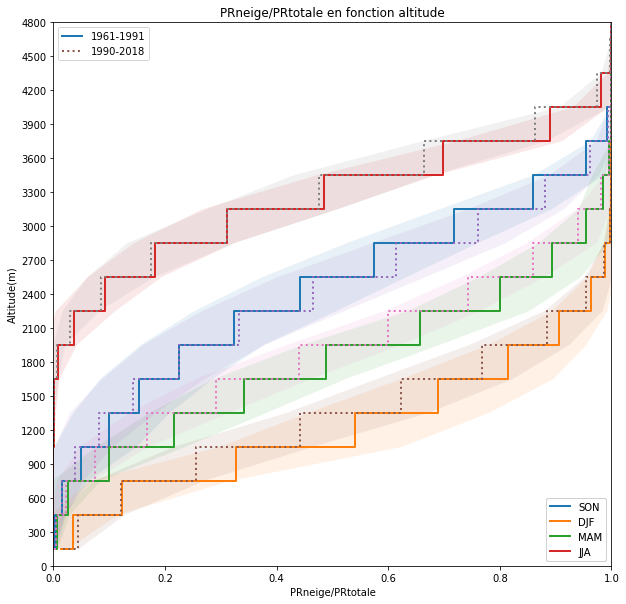

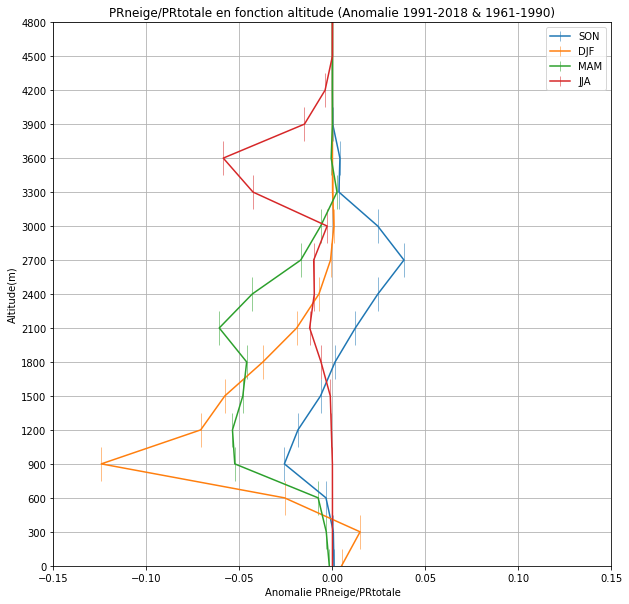

In [8]:
########################
### Analyse du Ratio ###
########################


### 1er FIG : altitudes/régions = f(ratio) avec STD sur années ###

linestyle = ['-',':']
fig, ax = plt.subplots(figsize=(10,10))


for j in range(0,2):
    
    x = data_per_x(calc_mean(file_meteo,'season'),'ZS',all_ZS,all_ZS,file_extra)
    x = x[1].sel(year = slice(yr_1[j],yr_2[j]))

    for i in x.season:
        ax.step(calc_ratio(x.mean(dim='year')).sel(season = i),x.ZS+150, where='mid', linestyle = linestyle[j],linewidth=2)
        ax.legend(x.season.values,loc='lower right')
        ax.set_ylabel('Altitude(m)')

        ax.set_xlabel('PRneige/PRtotale')
        ax.set_title('PRneige/PRtotale en fonction altitude')
        ax.set_xlim(0,1)
        ax.fill_betweenx(x.ZS+150,
             calc_ratio(x.mean(dim='year')).sel(season=i)+calc_ratio(x).std(dim = 'year').sel(season=i),
             calc_ratio(x.mean(dim='year')).sel(season=i)-calc_ratio(x).std(dim = 'year').sel(season=i),
            alpha = 0.1)
        ax.set_ylim(0,4800)
        ax.set_yticks(x.ZS)

lines = ax.get_lines()
legend1 = plt.legend([lines[k] for k in [0,5]], [str(yr_1[0])+'-'+str(yr_2[0]),str(yr_1[1])+'-'+str(yr_2[1])], loc="upper left")
legend2 = plt.legend([lines[k] for k in [0,1,2,3]], ['SON','DJF','MAM','JJA'], loc='lower right')
ax.add_artist(legend1)
ax.add_artist(legend2)

        
x = data_per_x(calc_mean(file_meteo,'season'),'ZS',all_ZS,all_ZS,file_extra)

diff = calc_ratio(x[1].sel(year = slice(yr_1[1],yr_2[1]))).mean(dim='year') - calc_ratio(x[1].sel(year = slice(yr_1[0],yr_2[0]))).mean(dim='year')

plt.figure(figsize=(10,10))

for i in diff.season:
    plt.errorbar(diff.sel(season = i),diff.ZS, yerr=150,elinewidth = (0.5))
    plt.legend(diff.season.values)
    plt.yticks(diff.ZS)
    plt.ylabel('Altitude(m)')

    plt.xlabel('Anomalie PRneige/PRtotale')
    plt.title('PRneige/PRtotale en fonction altitude (Anomalie 1991-2018 & 1961-1990)')
    plt.xlim(-0.15,0.15)
    plt.ylim(0,4800)

plt.grid()


[Text(0.5, 0, 'Month')]

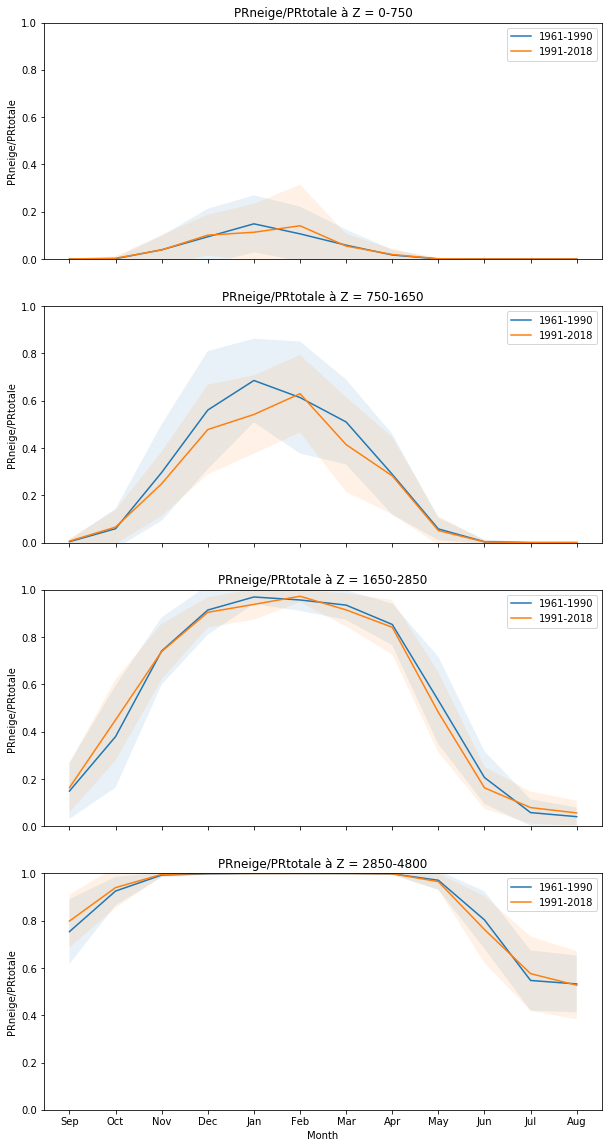

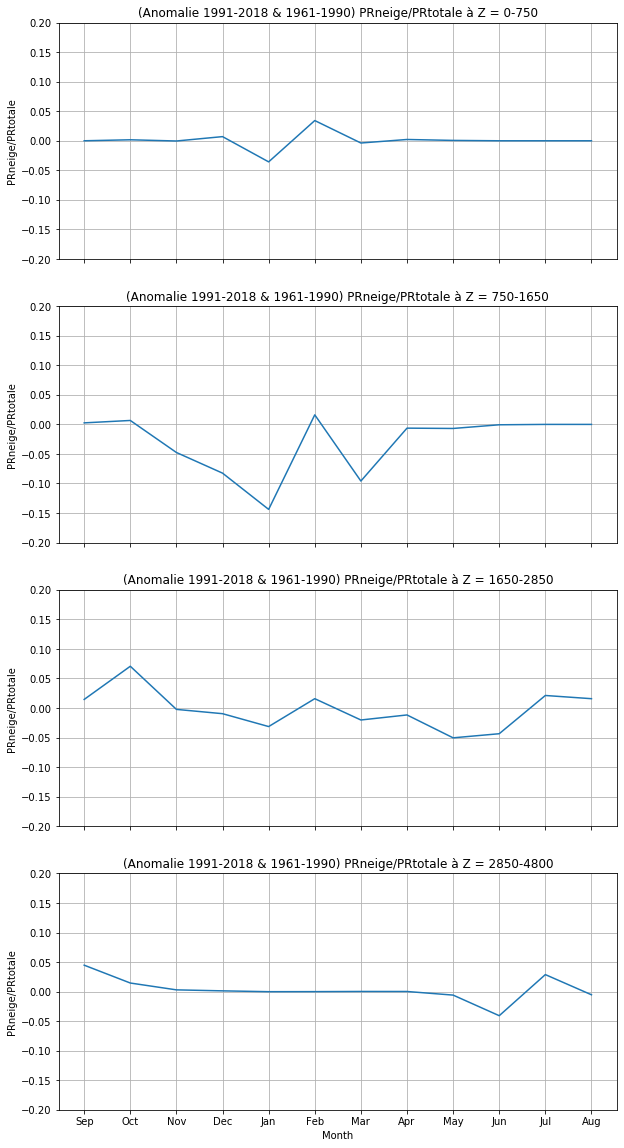

In [7]:
### 3eme FIG : Ratio = f(months) + ZS ### AVEC ANOMALIE

x = data_per_x(calc_mean(file_meteo,'month'),'ZS',range_ZS,range_ZS_name,file_extra)

x_1 = x[1].sel(year=slice(yr_11,yr_12)).mean(dim='year')
x_2 = x[1].sel(year=slice(yr_21,yr_22)).mean(dim='year')

std_1 = calc_ratio(x[1].sel(year=slice(yr_11,yr_12))).std(dim='year')
std_2 = calc_ratio(x[1].sel(year=slice(yr_21,yr_22))).std(dim='year')
   
fig, ax = plt.subplots(len(x_1.ZS), sharex='col', figsize=(10,20))

for i in range(0,len(range_ZS)):
    ax[i].plot(x_1.month,calc_ratio(x_1.isel(ZS = i)),label=(str(yr_11)+'-'+str(yr_12)))
    ax[i].plot(x_1.month,calc_ratio(x_2.isel(ZS = i)),label=(str(yr_21)+'-'+str(yr_22)))
    ax[i].set(ylabel='PRneige/PRtotale',
    title= 'PRneige/PRtotale à Z = '+range_ZS_name[i])
    ax[i].legend()
    ax[i].set_ylim([0,1])
    ax[i].fill_between(x[1].month,
                 calc_ratio(x_1.isel(ZS = i))+std_1.isel(ZS = i),
                 calc_ratio(x_1.isel(ZS = i))-std_1.isel(ZS = i),
                alpha = 0.1)

    ax[i].fill_between(x[1].month,
                 calc_ratio(x_2.isel(ZS = i))+std_2.isel(ZS = i),
                 calc_ratio(x_2.isel(ZS = i))-std_2.isel(ZS = i),
                alpha = 0.1)
    
ax[i].set(xlabel='Month')


diff = calc_ratio(x_2) - calc_ratio(x_1)

fig, ax = plt.subplots(len(diff.ZS), sharex='col', figsize=(10,20))

for i in range(0,len(range_ZS)):
    ax[i].plot(diff.month,diff.isel(ZS = i))
    ax[i].set(ylabel='PRneige/PRtotale',
    title= '(Anomalie 1991-2018 & 1961-1990) PRneige/PRtotale à Z = '+range_ZS_name[i])
    ax[i].set_ylim([-0.2,0.2])
    ax[i].grid()
ax[i].set(xlabel='Month')


In [9]:
########################
### Analyse PRtotale ###
########################

data_season = calc_mean(PR_tot,'season')
data_month = calc_mean(PR_tot,'month')

In [11]:
#######################################################################################
### Extrait des subsets de l'espace et fais l'ecart type intra categories du subset ###
#######################################################################################

# Tenter de remplacer Number of points par une dim generique
# Remplacer egalement la fonction calc_ratio par generique

def data_per_x(data,sthg,ls_sthg,ls_sthg_name,data_extra): #STHG = string de la variable, data = wat u want, ls_sthg = valeur intra catégories(liste de listes), ls_sthg_name = Nom des catégorie
    
    data_per_x = []
    std_intra_x = []
    
    for i in range(0,len(ls_sthg)):
        ds_res = data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])).mean(dim='Number_of_points')
        std = data.sel(Number_of_points = iextract(data_extra,sthg,ls_sthg[i])).std(dim='Number_of_points')
        data_per_x.append(ds_res)
        std_intra_x.append(std)

    data_per_x = xr.concat(data_per_x,dim = sthg)
    data_per_x[sthg] = ls_sthg_name
    std_intra_x = xr.concat(std_intra_x,dim =sthg)
    std_intra_x[sthg] = ls_sthg_name
    
    return std_intra_x,data_per_x

### Fonction extraction des indices ###

def iextract(data,variable,extract_list): # data = file_extra, variable = 'massif_number' or 'ZS', extract_list = Quelle liste/entier altitude ou de massif
    data = data[variable]
    iextract_list = []
    for i in range(0,len(data)):
        
        if type(extract_list) == int or type(extract_list) == np.int64 :
            if data[i].values == extract_list:
                iextract_list.append(i)
                
        else:
            for j in range(0,len(extract_list)):
                if data[i].values == extract_list[j]:
                    iextract_list.append(i)
    return iextract_list

In [21]:
########################################
### Function Calc_trend over dataset ###
########################################

def dataset_encoding(xds):
    cols = ['source', 'original_shape', 'dtype', 'zlib', 'complevel', 'chunksizes']
    info = pd.DataFrame(columns=cols, index=xds.data_vars)
    for row in info.index:
        var_encoding = xds[row].encoding
        for col in info.keys():
            info.ix[row, col] = var_encoding.pop(col, '')
    
    return info


def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes of the dataset (m = coords, n = time)
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
#    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
#    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

In [24]:
#############################################
### Calculate Trend over altitudes levels ###
#############################################

# RATIO

ratio_per_alt = data_per_x(calc_ratio(file_meteo),'ZS',range_ZS,range_ZS_name,file_extra)
LR_per_alt = xarray_trend(ratio_per_alt[1].transpose())
Slope_per_alt = LR_per_alt.slope*365*10
Slope_per_alt, LR_per_alt.pval

/home/monteiro/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(<xarray.DataArray 'slope' (ZS: 4)>
 array([ 0.00034435, -0.00913605, -0.01437919, -0.01123935])
 Coordinates:
   * ZS       (ZS) <U9 '0-750' '750-1650' '1650-2850' '2850-4800',
 <xarray.DataArray 'pval' (ZS: 4)>
 array([3.12394599e-01, 2.62996942e-13, 2.97098737e-22, 1.37406792e-25])
 Coordinates:
   * ZS       (ZS) <U9 '0-750' '750-1650' '1650-2850' '2850-4800'
 Attributes:
     info:     If p < 0.05 then the results from 'slope' are significant.)

In [25]:
#############################################
### Calculate Trend over altitudes levels ###
#############################################

# PRTOTALE

Pr_tot_per_alt = data_per_x(PR_tot,'ZS',range_ZS,range_ZS_name,file_extra)
LR_per_alt = xarray_trend(Pr_tot_per_alt[1].transpose())
Slope_per_alt = LR_per_alt.slope*365*10
Slope_per_alt, LR_per_alt.pval

(<xarray.DataArray 'slope' (ZS: 4)>
 array([-0.00354272, -0.00225906,  0.00077151,  0.0052989 ])
 Coordinates:
   * ZS       (ZS) <U9 '0-750' '750-1650' '1650-2850' '2850-4800',
 <xarray.DataArray 'pval' (ZS: 4)>
 array([0.42794885, 0.46310364, 0.48936908, 0.43643396])
 Coordinates:
   * ZS       (ZS) <U9 '0-750' '750-1650' '1650-2850' '2850-4800'
 Attributes:
     info:     If p < 0.05 then the results from 'slope' are significant.)

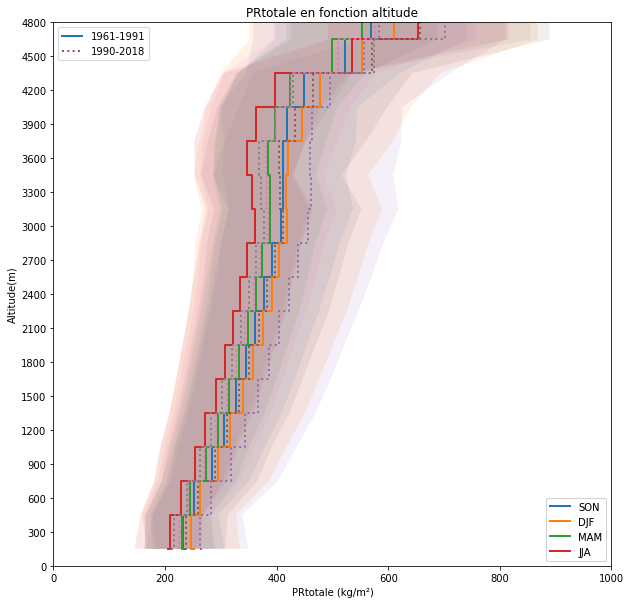

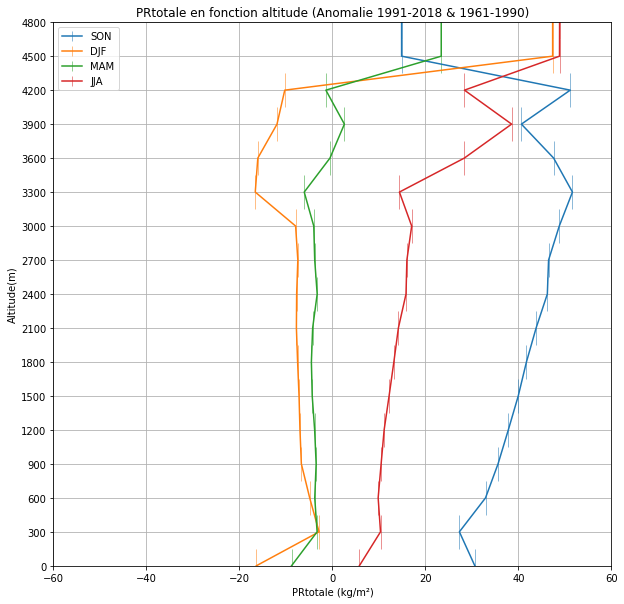

In [11]:
#########################
### Analyse du PRtot  ###
#########################

linestyle = ['-',':']
fig, ax = plt.subplots(figsize=(10,10))


for j in range(0,2):
    
    x = data_per_x(data_season,'ZS',all_ZS,all_ZS,file_extra)
    x = x[1].sel(year = slice(yr_1[j],yr_2[j]))
    
    for i in x.season:
        ax.step(x.mean(dim='year').sel(season = i),x.ZS+150, where='mid', linestyle = linestyle[j],linewidth=2)
        ax.legend(x.season.values,loc='lower right')
        ax.set_ylabel('Altitude(m)')

        ax.set_xlabel('PRtotale (kg/m²)')
        ax.set_title('PRtotale en fonction altitude')
        ax.set_xlim(0,1000)
        ax.set_ylim(0,4800)

        ax.fill_betweenx(x.ZS+150,
             x.mean(dim='year').sel(season=i)+x.std(dim = 'year').sel(season=i),
             x.mean(dim='year').sel(season=i)-x.std(dim = 'year').sel(season=i),
            alpha = 0.1)
        ax.set_yticks(x.ZS)

lines = ax.get_lines()
legend1 = plt.legend([lines[k] for k in [0,5]], [str(yr_1[0])+'-'+str(yr_2[0]),str(yr_1[1])+'-'+str(yr_2[1])], loc="upper left")
legend2 = plt.legend([lines[k] for k in [0,1,2,3]], ['SON','DJF','MAM','JJA'], loc='lower right')
ax.add_artist(legend1)
ax.add_artist(legend2) 

### 1er FIG : ANOMALIE altitudes/régions = f(PRtot) ###


x = data_per_x(data_season,'ZS',all_ZS,all_ZS,file_extra)

diff = x[1].sel(year = slice(yr_1[1],yr_2[1])).mean(dim='year') - x[1].sel(year = slice(yr_1[0],yr_2[0])).mean(dim='year')

plt.figure(figsize=(10,10))

for i in diff.season:
    plt.errorbar(diff.sel(season = i),diff.ZS, yerr=150,elinewidth = (0.5))
    plt.legend(diff.season.values)
    plt.yticks(diff.ZS)
    plt.ylabel('Altitude(m)')

    plt.xlabel('PRtotale (kg/m²)')
    plt.title('PRtotale en fonction altitude (Anomalie 1991-2018 & 1961-1990)')
    plt.xlim(-60,60)
    plt.ylim(0,4800)

plt.grid()

[Text(0.5, 0, 'Month')]

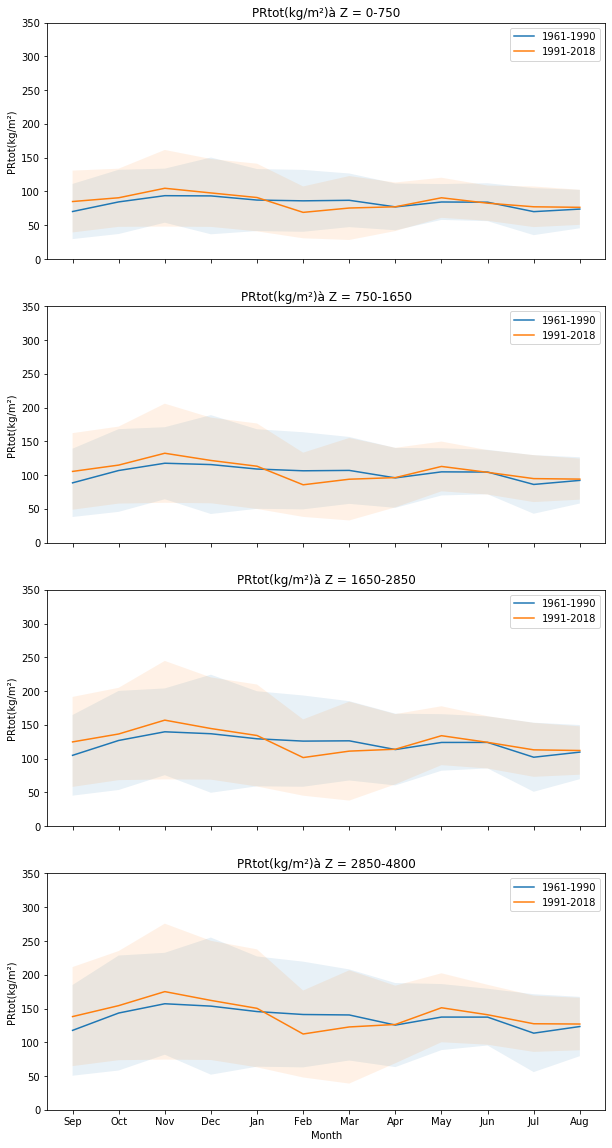

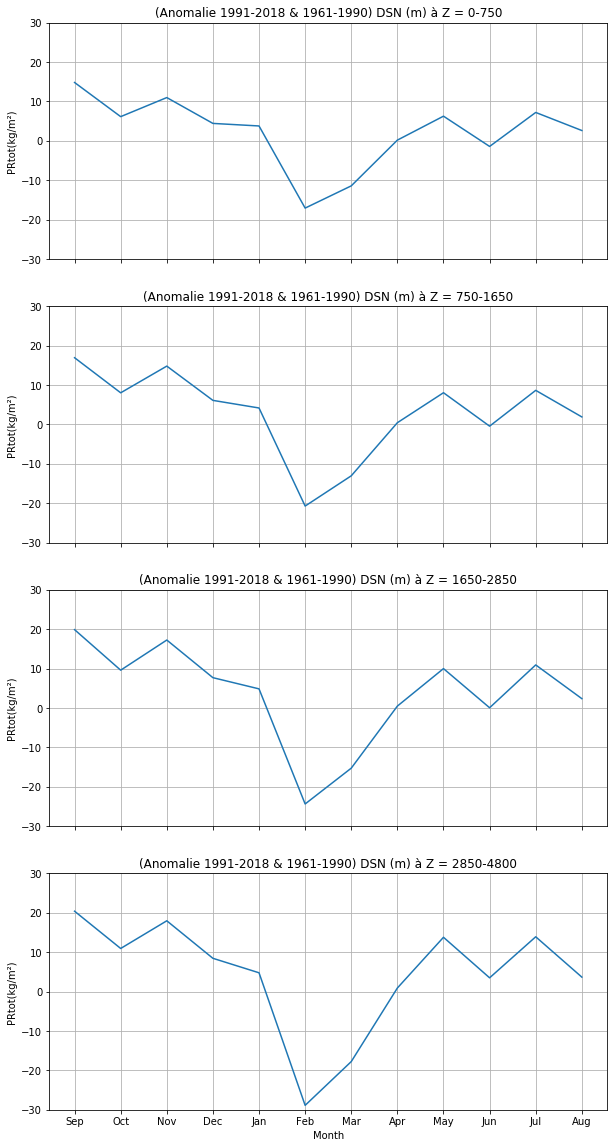

In [78]:
### 3eme FIG : PRtot = f(months) + ZS ### AVEC ANOMALIE

x = data_per_x(calc_mean(PR_tot,'month'),'ZS',range_ZS,range_ZS_name,file_extra)


x_1 = x[1].sel(year=slice(yr_11,yr_12)).mean(dim='year')
x_2 = x[1].sel(year=slice(yr_21,yr_22)).mean(dim='year')

std_1 = x[1].sel(year=slice(yr_11,yr_12)).std(dim='year')
std_2 = x[1].sel(year=slice(yr_21,yr_22)).std(dim='year')
   
fig, ax = plt.subplots(len(x_1.ZS), sharex='col', figsize=(10,20))

for i in range(0,len(range_ZS)):
    ax[i].plot(x_1.month,x_1.isel(ZS = i),label=(str(yr_11)+'-'+str(yr_12)))
    ax[i].plot(x_1.month,x_2.isel(ZS = i),label=(str(yr_21)+'-'+str(yr_22)))
    ax[i].set(ylabel='PRtot(kg/m²)',
    title= 'PRtot(kg/m²)à Z = '+range_ZS_name[i])
    ax[i].legend()
    ax[i].set_ylim([0,350])
    ax[i].fill_between(x[1].month,
                 x_1.isel(ZS = i)+std_1.isel(ZS = i),
                 x_1.isel(ZS = i)-std_1.isel(ZS = i),
                alpha = 0.1)

    ax[i].fill_between(x[1].month,
                 x_2.isel(ZS = i)+std_2.isel(ZS = i),
                 x_2.isel(ZS = i)-std_2.isel(ZS = i),
                alpha = 0.1)
    
ax[i].set(xlabel='Month')


diff = x_2 - x_1

fig, ax = plt.subplots(len(diff.ZS), sharex='col', figsize=(10,20))

for i in range(0,len(range_ZS)):
    ax[i].plot(diff.month,diff.isel(ZS = i))
    ax[i].set(ylabel='PRtot(kg/m²)',
    title= '(Anomalie 1991-2018 & 1961-1990) DSN (m) à Z = '+range_ZS_name[i])
    ax[i].set_ylim([-30,30])
    ax[i].grid()
ax[i].set(xlabel='Month')


In [ ]:
### NON UTILE ###

In [ ]:
### 3eme FIG : PRtot = f(months) + reg ### AVEC ANOMALIE

# fig, ax = plt.subplots(5, sharex='col', figsize=(10,20))
# fig1, ax1 = plt.subplots(5, sharex='col', figsize=(10,20))


# for j in range(0,len(all_reg_name)):

#     x1_mean = data_month.sel(year = slice(yr_11,yr_12),Number_of_points = all_reg[j]).mean(dim ='Number_of_points')
#     x1_std = x1_mean.std(dim='year')
#     x1_mean = x1_mean.mean(dim='year')

#     ax[j].plot(x1_mean.month,x1_mean,label=(str(yr_11)+'-'+str(yr_12)))

#     x2_mean = data_month.sel(year = slice(yr_21,yr_22),Number_of_points = all_reg[j]).mean(dim ='Number_of_points')
#     x2_std = x2_mean.std(dim='year')
#     x2_mean = x2_mean.mean(dim='year')

#     ax[j].plot(x2_mean.month,x2_mean,label=(str(yr_21)+'-'+str(yr_22)))
#     ax[j].legend()
#     ax[j].set(ylabel='PRtot(kg/m²)',
#     title= 'PRtot = f(month) '+str(all_reg_name[j])+' avec std intra clims')

#     ax[j].fill_between(x1_mean.month,
#                  x1_mean+x1_std,
#                  x1_mean-x1_std,
#                        alpha = 0.1)
#     ax[j].fill_between(x2_mean.month,
#                  x2_mean+x2_std,
#                  x2_mean-x2_std,
#                 alpha = 0.1)
#     ax[j].set_ylim(0,350)

#     diff_clim = x2_mean - x1_mean
#     ax1[j].plot(diff_clim.month, diff_clim)
#     ax1[j].set_ylim(-30,30)
#     ax1[j].grid()
#     ax1[j].set(xlabel = ('month'), ylabel = '(Anomalie 1991-2018 & 1961-1990)', title = str(all_reg_name[j]))


[Text(0.5, 0, 'Month')]

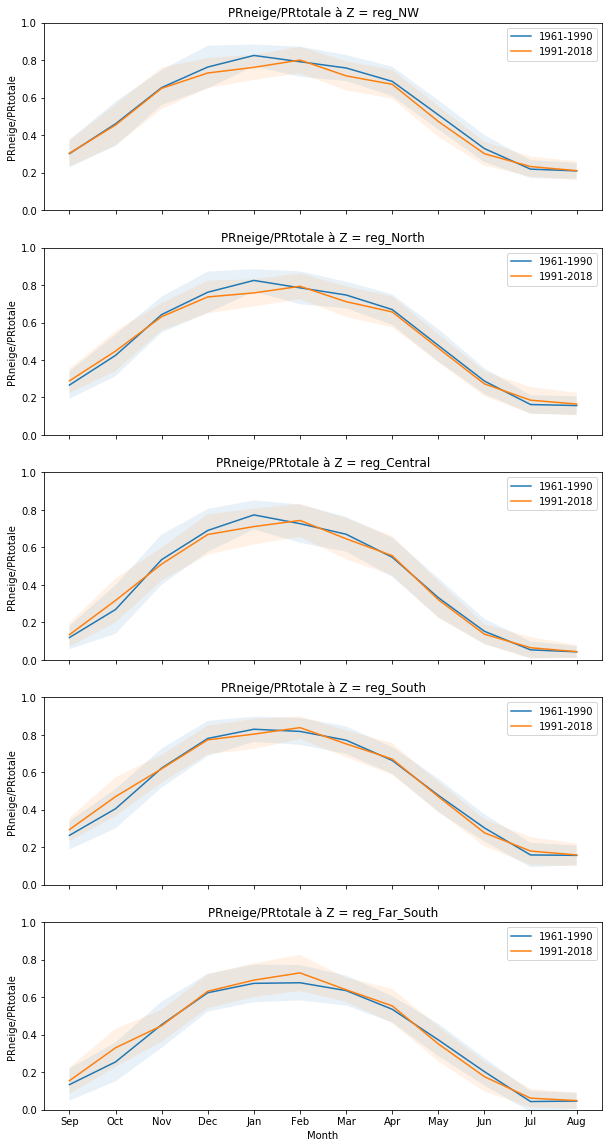

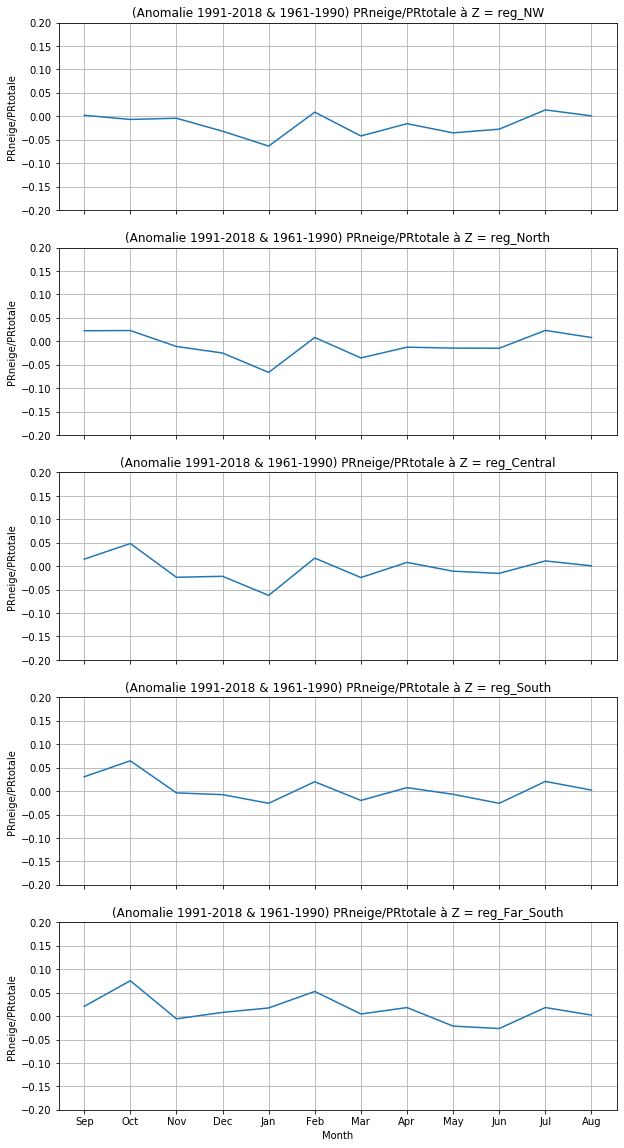

In [8]:
# ### 3eme FIG : Ratio = f(months) + reg ### AVEC ANOMALIE

# x = data_per_x(calc_mean(file_meteo,'month'),'massif_number',all_reg,all_reg_name,file_extra)

# x_1 = x[1].sel(year=slice(yr_11,yr_12)).mean(dim='year')
# x_2 = x[1].sel(year=slice(yr_21,yr_22)).mean(dim='year')

# std_1 = calc_ratio(x[1].sel(year=slice(yr_11,yr_12))).std(dim='year')
# std_2 = calc_ratio(x[1].sel(year=slice(yr_21,yr_22))).std(dim='year')
   
# fig, ax = plt.subplots(len(x_1.massif_number), sharex='col', figsize=(10,20))

# for i in range(0,len(all_reg)):
#     ax[i].plot(x_1.month,calc_ratio(x_1.isel(massif_number = i)),label=(str(yr_11)+'-'+str(yr_12)))
#     ax[i].plot(x_1.month,calc_ratio(x_2.isel(massif_number = i)),label=(str(yr_21)+'-'+str(yr_22)))
#     ax[i].set(ylabel='PRneige/PRtotale',
#     title= 'PRneige/PRtotale à Z = '+all_reg_name[i])
#     ax[i].legend()
#     ax[i].set_ylim([0,1])
#     ax[i].fill_between(x[1].month,
#                  calc_ratio(x_1.isel(massif_number = i))+std_1.isel(massif_number = i),
#                  calc_ratio(x_1.isel(massif_number = i))-std_1.isel(massif_number = i),
#                 alpha = 0.1)

#     ax[i].fill_between(x[1].month,
#                  calc_ratio(x_2.isel(massif_number = i))+std_2.isel(massif_number = i),
#                  calc_ratio(x_2.isel(massif_number = i))-std_2.isel(massif_number = i),
#                 alpha = 0.1)
    
# ax[i].set(xlabel='Month')


# diff = calc_ratio(x_2) - calc_ratio(x_1)

# fig, ax = plt.subplots(len(diff.massif_number), sharex='col', figsize=(10,20))

# for i in range(0,len(all_reg)):
#     ax[i].plot(diff.month,diff.isel(massif_number = i))
#     ax[i].set(ylabel='PRneige/PRtotale',
#     title= '(Anomalie 1991-2018 & 1961-1990) PRneige/PRtotale à Z = '+all_reg_name[i])
#     ax[i].set_ylim([-0.2,0.2])
#     ax[i].grid()
# ax[i].set(xlabel='Month')


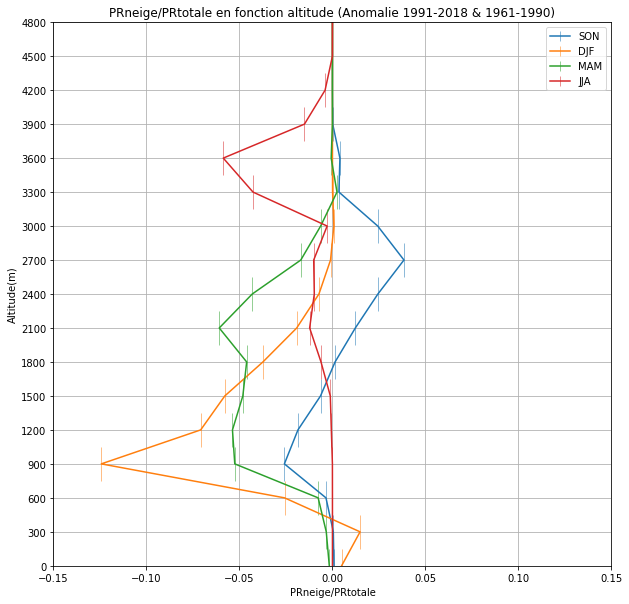

In [60]:
### 1er FIG : Repartition et ANOMALIE régions = f(ratio) ###

#     x = data_per_x(calc_mean(file_meteo,'season'),'massif_number',all_reg,all_reg_name,file_extra)
#     x = x[1].sel(year = slice(yr_1[j],yr_2[j]))

#     plt.figure(figsize=(15,15))

#     for i in x.season:
#         plt.plot(calc_ratio(x.mean(dim='year')).sel(season = i),x.massif_number)
#         plt.legend(x.season.values, fontsize=(25))
#         plt.yticks(x.massif_number, fontsize = (25))
#         plt.ylabel('Region',fontsize=(25))
#         plt.xlabel('PRneige/PRtotale', fontsize=(25))
#         plt.xticks(fontsize=(25))
#         plt.title('PRneige/PRtotale en fonction region (clim '+str(yr_1[j])+'-'+str(yr_2[j])+')', fontsize=(30))
#         plt.xlim(0,1)
#         plt.fill_betweenx(x.massif_number,
#                  calc_ratio(x.mean(dim='year')).sel(season=i)+calc_ratio(x).std(dim = 'year').sel(season=i),
#                  calc_ratio(x.mean(dim='year')).sel(season=i)-calc_ratio(x).std(dim = 'year').sel(season=i),
#                 alpha = 0.1)
#     plt.gca().invert_yaxis()


# x = data_per_x(calc_mean(file_meteo,'season'),'massif_number',all_reg,all_reg_name,file_extra)
# diff = calc_ratio(x[1].sel(year = slice(yr_1[1],yr_2[1]))).mean(dim='year') - calc_ratio(x[1].sel(year = slice(yr_1[0],yr_2[0]))).mean(dim='year')

# plt.figure(figsize=(15,15))

# for i in diff.season:
#     plt.plot(diff.sel(season = i),diff.massif_number)
#     plt.legend(diff.season.values, fontsize=(25))
#     plt.yticks(diff.massif_number, fontsize = (25))
#     plt.ylabel('Region',fontsize=(25))
#     plt.xlabel('PRneige/PRtotale', fontsize=(25))
#     plt.xticks(fontsize=(25))
#     plt.title('PRneige/PRtotale en fonction région (Anomalie 1989-2018 & 1959-1988)', fontsize=(30))
#     plt.xlim(-0.05,0.05)
# plt.gca().invert_yaxis()
# plt.grid()
